In this notebook we check how robest some key measures are upon different values of regularisation.

We will get plots for: clustering coeff, avg. degree, density, stress histograms, and subsetness.

In [41]:
""" Packages we'll need. """
%load_ext autoreload
%autoreload 2
import numpy as np
import pyreadstat as prs
import os
import sys
sys.path.append('../src')
from clean_data_1 import *
from clean_data_2 import transform_dataframe_2
from make_belief_network import make_belief_network
from make_belief_network import make_conditional_belief_network
from get_basic_graph_info import *
from display_network import *
from calc_stress import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
""" Importing the GSS dataset. """

raw_df, meta = prs.read_sas7bdat("../dat/gss7222_r3.sas7bdat")

""" Cleaning the data. """
 
df, metadata = transform_dataframe_1(raw_df)    # df contains all our data, metadata contains some other random shit 

KeyboardInterrupt: 

In [129]:
""" Setting the core replicating variables that we're interested in. """

variables = ["PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST", "BALLOT"]

In [15]:
import pandas as pd 
import numpy as np

start_year = 1990
end_year = 1994
duration = 4

# Create empty arrays to store network information. Variables are start year, R, num. nodes, num. edges, density, avg. degree, clustering coefficient, avg. shortest path length.
tracking_stats = {}
tracking_stats = {
    "start_year": [],
    "end_year": [],
    "R": [],
    "size": [],
    "num_edges": [],
    "density": [],
    "average_degree": [],
    "clustering_coefficient": [],
    "number_of_components": [],
    "percent_persistent_edges": []
    # "size_of_largest_component":[]        # This increases runtime a bit. Uncomment if you want to track this.
}

for i in range(start_year, end_year, 2):
    timeframe = list(range(i, i+duration))
    print("Timeframe: ", timeframe)
    for R in np.arange(0, 0.5, 0.01):
        BN, variables_list, correlation_matrix_partial = make_belief_network(df, variables, timeframe, method="spearman", is_partial=True, threshold=0, 
                                                                     sample_threshold=0, regularisation=R)
        network_info = {}
        network_info = get_network_info(correlation_matrix_partial, variables_list)

        tracking_stats["start_year"].append(i)
        tracking_stats["end_year"].append(i + duration)
        tracking_stats["R"].append(R)
        tracking_stats["size"].append(network_info['size'])
        tracking_stats["num_edges"].append(network_info['num_edges'])
        tracking_stats["density"].append(network_info['density'])
        tracking_stats["average_degree"].append(network_info['average_degree'])
        tracking_stats["clustering_coefficient"].append(network_info['global_properties']['clustering_coefficient'])
        tracking_stats["number_of_components"].append(network_info['number_of_components'])
        # tracking_stats["size_of_largest_component"].append(network_info['size_of_largest_component'])

        # Percent subgraph is the percent of nodes that is a subgraph of the BN for the previous value of R.

        if R == 0:
            tracking_stats["percent_persistent_edges"].append(0)
        else:
            # Get edges as sets
            edges_current = set(BN.edges())
            edges_previous = set(previous_BN.edges())

            # Count edges in current that are also in previous
            persistent_edges = edges_current.intersection(edges_previous)
            persistent_edges_count = len(persistent_edges)

            # Count number of edges in current
            current_edges_count = len(edges_current)

            # Calculate percent of edges in current that are also in previous
            percent_persistent_edges = persistent_edges_count / current_edges_count

            tracking_stats["percent_persistent_edges"].append(percent_persistent_edges)

        previous_BN = BN



Timeframe:  [1990, 1991, 1992, 1993]


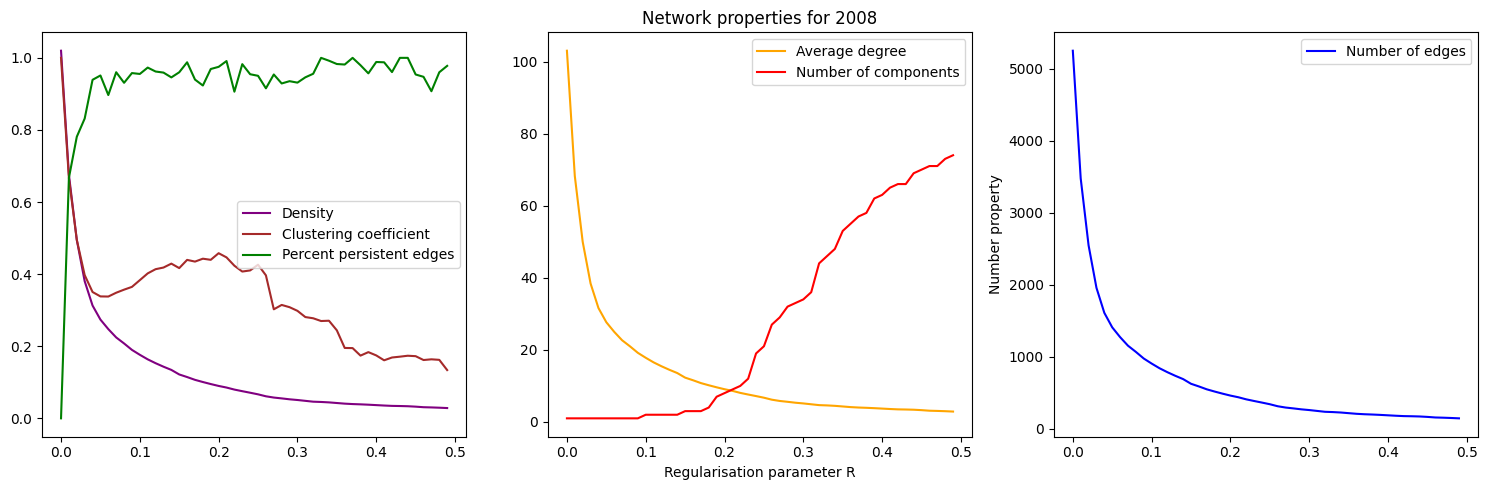

In [94]:
# stats_df = pd.DataFrame(tracking_stats)

import pandas as pd
stats_df = pd.read_csv("../out/analyses/regularisation_robustness_analysis_dataframe.csv")

# Filter data for the given year
year = 2008
df_year = stats_df[stats_df["start_year"] == year]

# Create subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Plot Number of Edges
axs[2].plot(df_year["R"], df_year["num_edges"], label="Number of edges", color="blue")
# axs[2].plot(df_year["R"], df_year["size_of_largest_component"]/len(BN), label="Size of largest component", color="blue")
axs[2].set_ylabel("Number property")
axs[2].legend(loc="best")

# Plot Size, Average Degree, and Number of Components
axs[1].plot(df_year["R"], df_year["average_degree"], label="Average degree", color="orange")
axs[1].plot(df_year["R"], df_year["number_of_components"], label="Number of components", color="red")
# axs[1].plot(df_year["R"], df_year["size"], label="Size", color="green")
axs[1].legend(loc="best")
axs[1].set_title(f"Network properties for {year}")
axs[1].set_xlabel("Regularisation parameter R")

# Plot Density and Clustering Coefficient
axs[0].plot(df_year["R"], df_year["density"], label="Density", color="purple")
axs[0].plot(df_year["R"], df_year["clustering_coefficient"], label="Clustering coefficient", color="brown")
axs[0].plot(df_year["R"], df_year["percent_persistent_edges"], label="Percent persistent edges", color="green")
axs[0].legend(loc="best")

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


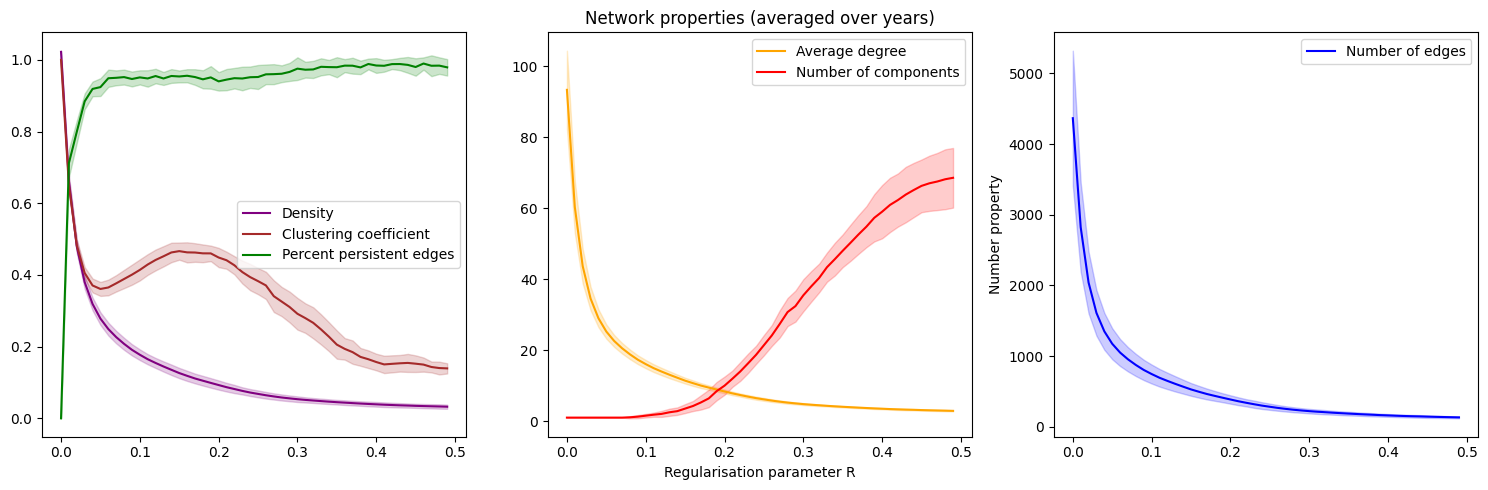

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
stats_df = pd.read_csv("../out/analyses/regularisation_robustness_analysis_dataframe.csv")

# Group data by the regularization parameter R
grouped = stats_df.groupby("R").agg(
    num_edges_mean=("num_edges", "mean"),
    num_edges_std=("num_edges", "std"),
    average_degree_mean=("average_degree", "mean"),
    average_degree_std=("average_degree", "std"),
    number_of_components_mean=("number_of_components", "mean"),
    number_of_components_std=("number_of_components", "std"),
    density_mean=("density", "mean"),
    density_std=("density", "std"),
    clustering_coefficient_mean=("clustering_coefficient", "mean"),
    clustering_coefficient_std=("clustering_coefficient", "std"),
    percent_persistent_edges_mean=("percent_persistent_edges", "mean"),
    percent_persistent_edges_std=("percent_persistent_edges", "std"),
    size_mean=("size", "mean"),
    size_std=("size", "std")
).reset_index()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Plot Number of Edges
axs[2].plot(grouped["R"], grouped["num_edges_mean"], label="Number of edges", color="blue")
axs[2].fill_between(grouped["R"], grouped["num_edges_mean"] - grouped["num_edges_std"], 
                    grouped["num_edges_mean"] + grouped["num_edges_std"], color="blue", alpha=0.2)
axs[2].set_ylabel("Number property")
axs[2].legend(loc="best")

# Plot Size, Average Degree, and Number of Components
axs[1].plot(grouped["R"], grouped["average_degree_mean"], label="Average degree", color="orange")
axs[1].fill_between(grouped["R"], grouped["average_degree_mean"] - grouped["average_degree_std"], 
                    grouped["average_degree_mean"] + grouped["average_degree_std"], color="orange", alpha=0.2)
axs[1].plot(grouped["R"], grouped["number_of_components_mean"], label="Number of components", color="red")
axs[1].fill_between(grouped["R"], grouped["number_of_components_mean"] - grouped["number_of_components_std"], 
                    grouped["number_of_components_mean"] + grouped["number_of_components_std"], color="red", alpha=0.2)
# axs[1].plot(grouped["R"], grouped["size_mean"], label="Size", color="green")
# axs[1].fill_between(grouped["R"], grouped["size_mean"] - grouped["size_std"], 
                    # grouped["size_mean"] + grouped["size_std"], color="green", alpha=0.2)
axs[1].legend(loc="best")
axs[1].set_title("Network properties (averaged over years)")
axs[1].set_xlabel("Regularisation parameter R")

# Plot Density, Clustering Coefficient, and Percent Persistent Edges
axs[0].plot(grouped["R"], grouped["density_mean"], label="Density", color="purple")
axs[0].fill_between(grouped["R"], grouped["density_mean"] - grouped["density_std"], 
                    grouped["density_mean"] + grouped["density_std"], color="purple", alpha=0.2)
axs[0].plot(grouped["R"], grouped["clustering_coefficient_mean"], label="Clustering coefficient", color="brown")
axs[0].fill_between(grouped["R"], grouped["clustering_coefficient_mean"] - grouped["clustering_coefficient_std"], 
                    grouped["clustering_coefficient_mean"] + grouped["clustering_coefficient_std"], color="brown", alpha=0.2)
axs[0].plot(grouped["R"], grouped["percent_persistent_edges_mean"], label="Percent persistent edges", color="green")
axs[0].fill_between(grouped["R"], grouped["percent_persistent_edges_mean"] - grouped["percent_persistent_edges_std"], 
                    grouped["percent_persistent_edges_mean"] + grouped["percent_persistent_edges_std"], color="green", alpha=0.2)
axs[0].legend(loc="best")

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


In [96]:
""" This takes ages to run, so we will save the dataframe to a csv file. """
""" We should also give it a very verbose and descriptive name. """

# stats_df.to_csv("../out/analyses/regularisation_robustness_analysis_dataframe.csv")



In [154]:
""" The next task to understand how robust the stress histograms are under different regularisation values. """
""" We will basically repeat the same process as above, but for the stress histograms. """

import pandas as pd 
import numpy as np

start_year = 1986
end_year = 2016
duration = 4

# Create empty arrays to store network information. Variables are start year, R, num. nodes, num. edges, density, avg. degree, clustering coefficient, avg. shortest path length.
tracking_stats = {}
tracking_stats = {
    "start_year": [],
    "end_year": [],
    "R": [],
    "total_stress_vectors": [],
    "BALLOT_1_stress_vectors": [],
    "BALLOT_2_stress_vectors": [],
    "BALLOT_3_stress_vectors": []
}

for i in range(start_year, end_year, 2):
    timeframe = list(range(i, i+duration))
    print("Timeframe: ", timeframe)
    for R in np.arange(0, 0.5, 0.01):
        BN, variables_list, correlation_matrix_partial = make_belief_network(df, variables, timeframe, method="spearman", is_partial=True, threshold=0, 
                                                                     sample_threshold=0, regularisation=R)

        df_b_vecs, meta_data_minsmaxs = transform_dataframe_2(df, metadata, timeframe)
        df_b_vecs = df_b_vecs.fillna(0)     # Replace NaNs with 0s
        df_b_vecs = normalise_columns(df_b_vecs, meta_data_minsmaxs)    # Normalise the data

        df_all_ballots = df_b_vecs[variables_list]   # Select only the variables that are in the BN
        df_ballot_1 = df_all_ballots[df_all_ballots["BALLOT"] == 1]
        df_ballot_2 = df_all_ballots[df_all_ballots["BALLOT"] == 2]
        df_ballot_3 = df_all_ballots[df_all_ballots["BALLOT"] == 3]

        belief_vectors_total = df_all_ballots.to_numpy()
        belief_vectors_ballot_1 = df_ballot_1.to_numpy()
        belief_vectors_ballot_2 = df_ballot_2.to_numpy()
        belief_vectors_ballot_3 = df_ballot_3.to_numpy()


        correlation_matrix_noDiag = correlation_matrix_partial - np.eye(correlation_matrix_partial.shape[0])    # Remove the diagonal of the correlation matrix

        stress_vec_total = [stress(belief_vectors_total[i,:], correlation_matrix_noDiag) for i in range(belief_vectors_total.shape[0])]
        stress_vec_ballot_1 = [stress(belief_vectors_ballot_1[i,:], correlation_matrix_noDiag) for i in range(belief_vectors_ballot_1.shape[0])]
        stress_vec_ballot_2 = [stress(belief_vectors_ballot_2[i,:], correlation_matrix_noDiag) for i in range(belief_vectors_ballot_2.shape[0])]
        stress_vec_ballot_3 = [stress(belief_vectors_ballot_3[i,:], correlation_matrix_noDiag) for i in range(belief_vectors_ballot_3.shape[0])]

        tracking_stats["start_year"].append(i)
        tracking_stats["end_year"].append(i + duration)
        tracking_stats["R"].append(R)
        tracking_stats["total_stress_vectors"].append(stress_vec_total)
        tracking_stats["BALLOT_1_stress_vectors"].append(stress_vec_ballot_1)
        tracking_stats["BALLOT_2_stress_vectors"].append(stress_vec_ballot_2)
        tracking_stats["BALLOT_3_stress_vectors"].append(stress_vec_ballot_3)
        




Timeframe:  [1986, 1987, 1988, 1989]
Timeframe:  [1988, 1989, 1990, 1991]
Timeframe:  [1990, 1991, 1992, 1993]
Timeframe:  [1992, 1993, 1994, 1995]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -1.125e-03



Timeframe:  [1994, 1995, 1996, 1997]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -6.873e-04



Timeframe:  [1996, 1997, 1998, 1999]
Timeframe:  [1998, 1999, 2000, 2001]
Timeframe:  [2000, 2001, 2002, 2003]
Timeframe:  [2002, 2003, 2004, 2005]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -3.184e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -1.093e-04



Timeframe:  [2004, 2005, 2006, 2007]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -6.987e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -6.499e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -5.096e-04



Timeframe:  [2006, 2007, 2008, 2009]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: 8.029e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -6.603e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -5.646e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -3.689e-04



Timeframe:  [2008, 2009, 2010, 2011]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -1.617e-03

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: 7.021e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -3.302e-04



Timeframe:  [2010, 2011, 2012, 2013]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: 3.570e-03

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -3.351e-04



Timeframe:  [2012, 2013, 2014, 2015]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: 2.871e-03

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -1.531e-04



Timeframe:  [2014, 2015, 2016, 2017]


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: 4.200e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -4.136e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -3.790e-04

c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -2.721e-04



In [155]:
# stress_vector_df = pd.DataFrame(tracking_stats)
# stress_vector_df.to_csv("../out/analyses/regularisation_robustness_analysis_dataframe_stress_histograms.csv")


    start_year  end_year     R  \
22        1990      1994  0.22   

                                 total_stress_vectors  \
22  [-0.8890853537206975, -2.267320618794687, -15....   

                              BALLOT_1_stress_vectors  \
22  [-15.472862098295991, -23.237848377122965, -8....   

                              BALLOT_2_stress_vectors  \
22  [-0.8890853537206975, -2.267320618794687, -4.5...   

                              BALLOT_3_stress_vectors  
22  [-18.573879703500918, -9.493633962635023, -13....  


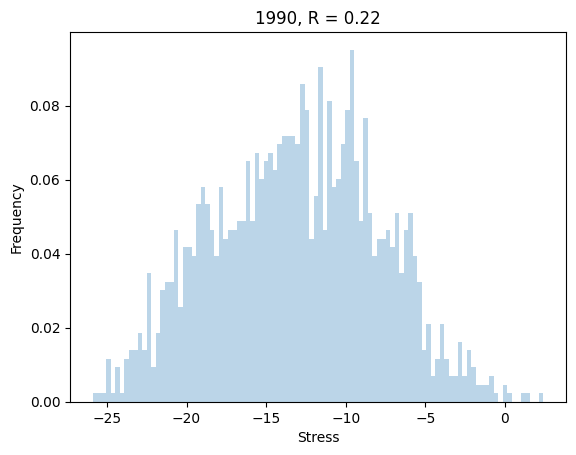

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming tracking_stats is already defined somewhere in your code
# Example: tracking_stats = {'start_year': [1990, 1991, ...], 'R': [0.1, 0.15, ...], 'stress_vectors': [[...], [...], ...]}

# Filter data for the given year
year = 1990
df_year = stress_vector_df[stress_vector_df["start_year"] == year]

# Filter to a specific regularisation parameter
R = 0.22
df_R = df_year[df_year["R"] == R]

# Get the stress vector

print(df_R)
stress_vec = df_R["BALLOT_1_stress_vectors"].values[0]

# Create subplots
bin_resolution = 50
plt.hist(stress_vec, bins=100, alpha=0.3, density=True)
plt.xlabel('Stress')
plt.ylabel('Frequency')
plt.title(f'{year}, R = {R}')
plt.show()


In [174]:
import pandas as pd
import plotly.graph_objects as go
import ast
from ipywidgets import interact, FloatSlider, IntSlider

stress_vector_df = pd.read_csv("../out/analyses/regularisation_robustness_analysis_dataframe_stress_histograms.csv", index_col=0)

print(stress_vector_df["total_stress_vectors"][0])

# Define the interactive function
def plot_histogram(year, R, ballot):
    df_year = stress_vector_df[stress_vector_df["start_year"] == year]
    df_R = df_year[df_year["R"] == R]

    stress_vec = []
    if not df_R.empty:
        if ballot == 0:
            stress_vec = df_R["total_stress_vectors"].values[0]
        else:
            stress_vec = df_R[f"BALLOT_{ballot}_stress_vectors"].values[0]        
            
        stress_vec = ast.literal_eval(stress_vec) # For some reason when I import the df from csv, the stress vector is a string. This fixes the issue. 

        fig = go.Figure(data=[go.Histogram(x=stress_vec, nbinsx=100, histnorm='probability')])
        
        fig.update_layout(
        title=f'Stress Histogram for Year {year} and Regularisation Parameter {R}',
        xaxis_title='Stress',
        yaxis_title='Frequency'
        # Make x- and y-axes constant for all plots
        # xaxis=dict(range=[0, 1]),
        # yaxis=dict(range=[0, 1])
        )
        fig.show()

# Get unique years and R values
years = sorted(stress_vector_df["start_year"].unique())
R_values = sorted(stress_vector_df["R"].unique())

# Create interactive widget with sliders
year_slider = IntSlider(min=min(years), max=max(years), step=1, value=min(years))
R_slider = FloatSlider(min=min(R_values), max=max(R_values), step=0.01, value=min(R_values))
ballot_slider = IntSlider(min=0, max=3, step=1, value=0)


interact(plot_histogram, year=year_slider, R=R_slider, ballot=ballot_slider)


[-7.687353587940409, -11.515839712899272, -6.315789780722243, -23.334663395148795, -19.446844527695212, -22.090884950729006, -7.658019889383175, -17.96524604245453, -11.335682679639277, -11.935472399074623, -9.341944533242948, -4.172728727376203, -23.56951149415808, -14.55150347154837, -10.319221574149239, -9.07299401023231, -18.428781783637127, -16.95651179440827, -22.14313577872116, -11.955195622445407, -14.661371546185933, -9.280442601778827, -14.401022469531574, -11.577793739706886, -14.802256137023258, -12.083148094448834, -13.347107923854297, -15.356413387538923, -8.691921884551082, -4.817522692563269, -7.100631869499644, -16.18485980205437, -13.983823544335896, -6.625203807224028, -16.552340967375944, -15.28556767230458, -17.34042448418602, -11.790491650779458, -13.171968589540757, -14.76997913673928, -12.508295504280603, -9.214248660756368, -8.709122738625261, -10.297265613734496, -11.041538538204419, -21.42760358593479, -5.3747567200103035, -9.820806742719974, -12.897507405776

interactive(children=(IntSlider(value=1986, description='year', max=2014, min=1986), FloatSlider(value=0.0, de…

<function __main__.plot_histogram(year, R, ballot)>